In [172]:
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
import tensorflow as tf
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd

### Get Data ###

In [173]:
df_image = pd.read_csv('label_and_path.csv')
X_image = df_image[:770]['image_path'].values

df_meta = pd.read_csv('skin_data.csv')
X_meta = df_meta[:770].drop(columns=['target']).values

y = df_image[:770]['target'].values

### Split Data ###

In [174]:
# Split for images
X_train_image, X_val_test_image, y_train_image, y_val_test_image = train_test_split(X_image, y, test_size=0.3, stratify=y)
X_val_image, X_test_image, y_val_image, y_test_image = train_test_split(X_val_test_image, y_val_test_image, test_size=0.5, stratify=y_val_test_image)

# Split for metadata
X_train_meta, X_val_test_meta, y_train_meta, y_val_test_meta = train_test_split(X_meta, y, test_size=0.3, stratify=y)
X_val_meta, X_test_meta, y_val_meta, y_test_meta = train_test_split(X_val_test_meta, y_val_test_meta, test_size=0.5, stratify=y_val_test_meta)

In [175]:
count_y_train_image = np.sum(y_train_image == 1)
count_y_val_image = np.sum(y_val_image == 1)
count_y_test_image = np.sum(y_test_image == 1)

count_y_train_meta = np.sum(y_train_meta == 1)
count_y_val_meta = np.sum(y_val_meta == 1)
count_y_test_meta = np.sum(y_test_meta == 1)

print(f"Number of labels that are 1 in y_train_image: {count_y_train_image}")
print(f"Number of labels that are 1 in y_val_image: {count_y_val_image}")
print(f"Number of labels that are 1 in y_test_image: {count_y_test_image}")

print(f"Number of labels that are 1 in y_train_meta: {count_y_train_meta}")
print(f"Number of labels that are 1 in y_val_meta: {count_y_val_meta}")
print(f"Number of labels that are 1 in y_test_meta: {count_y_test_meta}")

Number of labels that are 1 in y_train_image: 267
Number of labels that are 1 in y_val_image: 57
Number of labels that are 1 in y_test_image: 57
Number of labels that are 1 in y_train_meta: 267
Number of labels that are 1 in y_val_meta: 57
Number of labels that are 1 in y_test_meta: 57


In [176]:
def preprocess_combined(image_path, metadata, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (128, 128))
    image = tf.cast(image, tf.float32) / 255.0
    return (image, metadata), label

def create_combined_dataset(image_paths, metadata, labels, batch_size=32, shuffle=True):
    image_paths = tf.constant(image_paths)
    metadata = tf.convert_to_tensor(metadata, dtype=tf.float32)
    labels = tf.convert_to_tensor(labels, dtype=tf.float32)

    ds = tf.data.Dataset.from_tensor_slices((image_paths, metadata, labels))
    ds = ds.map(preprocess_combined, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(buffer_size=1000)

    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds


In [177]:
train_ds = create_combined_dataset(X_train_image, X_train_meta, y_train_image, batch_size=256)
val_ds = create_combined_dataset(X_val_image, X_val_meta, y_val_image, batch_size=256, shuffle=False)
test_ds = create_combined_dataset(X_test_image, X_test_meta, y_test_image, batch_size=256, shuffle=False)

### CNN + MLP ###

In [178]:

# CNN Model
def CNN_model(input_shape=(128, 128, 3)):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = True  # Allow fine-tuning of the base model
    
    x = MaxPooling2D()(base_model.output)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    
    return Model(inputs=base_model.input, outputs=x, name='cnn_model')


# MLP Model
def MLP_model(input_dim):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(64, activation='relu')(inputs)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(df_meta.shape[1], activation='relu')(x)
    
    return models.Model(inputs=inputs, outputs=x, name='metadata_model')


# Combined Model
def build_combined_model(image_shape, metadata_dim):
    cnn_model = CNN_model(image_shape)
    mlp_model = MLP_model(metadata_dim)

    # Flatten the CNN output to make it 2D
    cnn_flattened = layers.Flatten()(cnn_model.output)

    # Fusion
    combined = layers.concatenate([cnn_flattened, mlp_model.output])
    x = layers.Dense(64, activation='relu')(combined)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(1, activation='sigmoid')(x)  # Connect the output layer to `x`

    model = models.Model(inputs=[cnn_model.input, mlp_model.input], outputs=output)
    return model

In [179]:
model = build_combined_model(image_shape=(128, 128, 3), metadata_dim=X_train_meta.shape[1])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Early stopping
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stopping_callback]
)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 117s 15s/step - accuracy: 0.4841 - loss: 12.4879 - val_accuracy: 0.4957 - val_loss: 44.7415
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 43s 12s/step - accuracy: 0.6064 - loss: 7.7157 - val_accuracy: 0.4957 - val_loss: 17.1843
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 43s 11s/step - accuracy: 0.7429 - loss: 6.3127 - val_accuracy: 0.4957 - val_loss: 35.3970
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 47s 12s/step - accuracy: 0.7308 - loss: 3.8255 - val_accuracy: 0.4957 - val_loss: 29.4501
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 40s 11s/step - accuracy: 0.7515 - loss: 3.4253 - val_accuracy: 0.4957 - val_loss: 77.6686
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 46s 11s/step - accuracy: 0.7649 - loss: 2.4555 - val_accuracy: 0.4957 - val_loss: 96.1558
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 41s 11s/step - accuracy: 0.8056 - loss: 1.7173 - val_accuracy: 0.4957 - val_loss: 241.7265


In [180]:
# model.save('combined_model2.h5')

In [181]:
test_probs = model.predict(test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step


In [182]:
test_probs = np.array(test_probs).flatten()

In [183]:
print(test_probs[test_probs > 0.5])

[1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 0.9999939 1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.       

In [184]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4914 - loss: 17.8571
Test Loss: 17.857051849365234
Test Accuracy: 0.4913793206214905


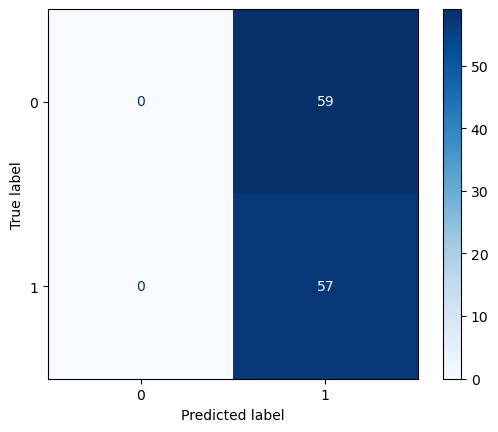

In [185]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming test_probs contains the predicted probabilities, we convert them to binary predictions
y_pred = (test_probs > 0.5).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(y_test_image, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')

In [188]:
# Count labels with 1 and 2 in each set
count_y_train_image_1 = np.sum(y_train_image == 1)
count_y_train_image_2 = np.sum(y_train_image == 0)

count_y_val_image_1 = np.sum(y_val_image == 1)
count_y_val_image_2 = np.sum(y_val_image == 0)

count_y_test_image_1 = np.sum(y_test_image == 1)
count_y_test_image_2 = np.sum(y_test_image == 0)

print(f"Train set - Labels with 1: {count_y_train_image_1}, Labels with 0: {count_y_train_image_2}")
print(f"Validation set - Labels with 1: {count_y_val_image_1}, Labels with 0: {count_y_val_image_2}")
print(f"Test set - Labels with 1: {count_y_test_image_1}, Labels with 0: {count_y_test_image_2}")

Train set - Labels with 1: 267, Labels with 0: 272
Validation set - Labels with 1: 57, Labels with 0: 58
Test set - Labels with 1: 57, Labels with 0: 59


### Auto Encoder ###

# Define the convolutional autoencoder architecture
input_shape = X_train.shape[1:]

# Input layer
input_layer = Input(shape=input_shape)

# Encoding layers
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoding layers
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(input_shape[2], (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder model
autoencoder = Model(input_layer, decoded)

# Encoder model
encoder = Model(input_layer, encoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Early stopping
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=1, batch_size=256, shuffle=True, validation_data=(X_val, X_val), callback=[early_stopping_callback])

# Encode the validation data
encoded_val = encoder.predict(X_val)

# Detect anomalies using reconstruction loss
reconstructed_val = autoencoder.predict(X_val)
reconstruction_error = np.mean((X_val - reconstructed_val) ** 2, axis=(1, 2, 3))

# Set a threshold for anomaly detection
threshold = reconstruction_error.mean() + 2 * reconstruction_error.std()

# Identify anomalies
anomalies = reconstruction_error > threshold
print("Number of anomalies detected:", anomalies.sum())